In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import BertTokenizer
import pickle

from textattack.models.wrappers import ModelWrapper
from textattack.datasets import HuggingFaceDataset
from textattack.attack_recipes import PWWSRen2019
from textattack import Attacker, AttackArgs

In [2]:
import torch
from torch.nn import CrossEntropyLoss
import textattack
from model_wrapper import ModelWrapper

from models import model_1 as mm

In [3]:
torch.cuda.empty_cache()

### PyTorchModelWrapper

In [4]:
class PyTorchModelWrapper(ModelWrapper):
    """Loads a PyTorch model (`nn.Module`) and tokenizer.

    Args:
        model (torch.nn.Module): PyTorch model
        tokenizer: tokenizer whose output can be packed as a tensor and passed to the model.
            No type requirement, but most have `tokenizer` method that accepts list of strings.
    """

    def __init__(self, model, tokenizer):
        if not isinstance(model, torch.nn.Module):
            raise TypeError(
                f"PyTorch model must be torch.nn.Module, got type {type(model)}"
            )

        self.model = model
        self.tokenizer = tokenizer

    def to(self, device):
        self.model.to(device)

    def __call__(self, text_input_list, batch_size=32):
        model_device = next(self.model.parameters()).device
        ############################################################ Change 1
        ids = self.tokenizer(text_input_list, return_tensors="pt", padding=True)
        ids = ids.to(model_device)

        with torch.no_grad():
            outputs = textattack.shared.utils.batch_model_predict(
                self.model, ids, batch_size=batch_size
            )

        return outputs

    def get_grad(self, text_input, loss_fn=CrossEntropyLoss()):
        """Get gradient of loss with respect to input tokens.

        Args:
            text_input (str): input string
            loss_fn (torch.nn.Module): loss function. Default is `torch.nn.CrossEntropyLoss`
        Returns:
            Dict of ids, tokens, and gradient as numpy array.
        """

        if not hasattr(self.model, "get_input_embeddings"):
            raise AttributeError(
                f"{type(self.model)} must have method `get_input_embeddings` that returns `torch.nn.Embedding` object that represents input embedding layer"
            )
        if not isinstance(loss_fn, torch.nn.Module):
            raise ValueError("Loss function must be of type `torch.nn.Module`.")

        self.model.train()

        embedding_layer = self.model.get_input_embeddings()
        original_state = embedding_layer.weight.requires_grad
        embedding_layer.weight.requires_grad = True

        emb_grads = []

        def grad_hook(module, grad_in, grad_out):
            emb_grads.append(grad_out[0])

        emb_hook = embedding_layer.register_backward_hook(grad_hook)

        self.model.zero_grad()
        model_device = next(self.model.parameters()).device
        
        ######################################################### Change 2
        ids = self.tokenizer(text_input_list, return_tensors="pt", padding=True)
        ids = ids.to(model_device)

        predictions = self.model(ids)

        output = predictions.argmax(dim=1)
        loss = loss_fn(predictions, output)
        loss.backward()

        # grad w.r.t to word embeddings

        # Fix for Issue #601

        # Check if gradient has shape [max_sequence,1,_] ( when model input in transpose of input sequence)

        if emb_grads[0].shape[1] == 1:
            grad = torch.transpose(emb_grads[0], 0, 1)[0].cpu().numpy()
        else:
            # gradient has shape [1,max_sequence,_]
            grad = emb_grads[0][0].cpu().numpy()

        embedding_layer.weight.requires_grad = original_state
        emb_hook.remove()
        self.model.eval()

        output = {"ids": ids[0].tolist(), "gradient": grad}

        return output

    def _tokenize(self, inputs):
        """Helper method that for `tokenize`
        Args:
            inputs (list[str]): list of input strings
        Returns:
            tokens (list[list[str]]): List of list of tokens as strings
        """
        return [self.tokenizer.convert_ids_to_tokens(self.tokenizer(x)) for x in inputs]

### Self Tx

In [5]:
d_model = 768
max_token = 512
nhead = 12
nlayer = 6
device = "cuda"

In [6]:
with open("bert_embedding.pkl", "rb") as file:
    embd = pickle.load(file)

In [7]:
model = mm.ad_transformer(d_model,nhead, nlayer, max_token, embd, device).to(device)

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
model.load_state_dict(torch.load("weight_trained_1.pth"))

<All keys matched successfully>

### Spam Dataset

In [10]:
#f = pd.read_csv("dataset/spam_train.csv")

In [11]:
#df = df.drop("len", axis=1)

In [12]:
### Removing Sequence more than 500 tokens
#tok_threshold = []
#for i in range(len(df) - 1, -1, -1):
#    tok_len = len(tokenizer(df.iloc[i,1], return_tensors="pt", padding=True)["input_ids"][0])
#    if tok_len > 500:
#        tok_threshold.append(i)
#        
#df.drop(859, inplace=True)

In [13]:
#df = df[df["text_type"] == "spam"]

In [14]:
#df_test.to_csv("attack_spam_only.csv", index = False)

In [15]:
df_test = pd.read_csv("dataset/attack_test.csv")

In [16]:
df_test = df_test.replace("spam",0)

### Testing Acurracy

In [17]:
## Actual Value (SPAM, HAM)  ## Y - Predicted Value (SPAM, HAM)
#conf_matrix = np.zeros((2,2))

In [18]:
"""
for i in range(len(df_test)):
    input_list = df_test.iloc[i,1]
    tok_input = tokenizer(input_list, return_tensors="pt", padding=True).to(device)
    out = model(tok_input)
    
    index_1 = torch.argmax(out[0]).tolist()
    
    if df_test.iloc[i,0] == 0:
        index_2 = 0
    else:
        index_2 = 1
        
    conf_matrix[index_1][index_2] += 1
"""

'\nfor i in range(len(df_test)):\n    input_list = df_test.iloc[i,1]\n    tok_input = tokenizer(input_list, return_tensors="pt", padding=True).to(device)\n    out = model(tok_input)\n    \n    index_1 = torch.argmax(out[0]).tolist()\n    \n    if df_test.iloc[i,0] == 0:\n        index_2 = 0\n    else:\n        index_2 = 1\n        \n    conf_matrix[index_1][index_2] += 1\n'

In [19]:
#conf_matrix

### Attack

In [20]:
df_test = df_test.rename(columns={'text_type': 'label'})

In [21]:
model_wrapper = PyTorchModelWrapper(model, tokenizer)

In [22]:
from textattack import Attack
from textattack.search_methods import GreedySearch
from textattack.constraints.pre_transformation import (
    RepeatModification,
    StopwordModification,
)
from textattack.goal_functions import UntargetedClassification, TargetedClassification
from textattack.transformations import WordSwapEmbedding
from textattack.constraints.pre_transformation import RepeatModification
from textattack.constraints.pre_transformation import StopwordModification

In [23]:
goal_function = TargetedClassification(model_wrapper, target_class = 1)

transformation = WordSwapEmbedding()

constraints = [RepeatModification(), StopwordModification()]

search_method = GreedySearch()

attack = Attack(goal_function, constraints, transformation, search_method)

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.


In [24]:
custom_ds = []
for i in range(len(df_test)):
    custom_ds.append((df_test.iloc[i,1], int(df_test.iloc[i,0])))

In [25]:
dataset = textattack.datasets.Dataset(custom_ds)

### Getting Low Rank of only Attention Weights

In [26]:
def svd_sa(model, rank):
    all_model_weight = model.state_dict()
    
    for layer_num in range(nlayer):
        layer_name = 'transformer_encoder.layers.' + str(layer_num) + '.self_attn.in_proj_weight'

        in_proj_weight = all_model_weight[layer_name]
        q, k, v = torch.split(in_proj_weight, [d_model, d_model, d_model])

        U, s, V = np.linalg.svd(q.to("cpu").numpy())
        low_rank_mat = np.dot(U[:, :rank], np.dot(np.diag(s[:rank]), V[:rank, :]))
        q = low_rank_mat

        U, s, V = np.linalg.svd(k.to("cpu").numpy())
        low_rank_mat = np.dot(U[:, :rank], np.dot(np.diag(s[:rank]), V[:rank, :]))
        k = low_rank_mat

        U, s, V = np.linalg.svd(v.to("cpu").numpy())
        low_rank_mat = np.dot(U[:, :rank], np.dot(np.diag(s[:rank]), V[:rank, :]))
        v = low_rank_mat

        all_model_weight[layer_name] = torch.concat((torch.tensor(q),torch.tensor(k), torch.tensor(v))).to("cuda")
        
    return all_model_weight

### Experimenting on different rank

In [40]:
transformation = WordSwapEmbedding()
constraints = [RepeatModification(), StopwordModification()]
search_method = GreedySearch()

In [ ]:
for rank in range(1, 50, 5):
    model.load_state_dict(torch.load("weight_trained_1.pth"))
    
    all_model_weight = svd_sa(model, rank)
    model.load_state_dict(all_model_weight)
    
    model_wrapper = PyTorchModelWrapper(model, tokenizer)
    goal_function = TargetedClassification(model_wrapper, target_class = 1)
    attack = Attack(goal_function, constraints, transformation, search_method)
    
    attack_args = textattack.AttackArgs(
    num_examples=30,
    log_to_csv="rank/log_"+str(rank)+".csv",
    checkpoint_interval=5,
    checkpoint_dir="checkpoints",
    disable_stdout=True
    )
    
    attacker = Attacker(attack, dataset, attack_args)
    attacker.attack_dataset()

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_1.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 




  3%|████▏                                                                                                                       | 1/30 [00:15<07:37, 15.77s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   3%|██▎                                                                   | 1/30 [00:15<07:37, 15.79s/it]
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   7%|████▋                                                                 | 2/30 [00:37<08:46, 18.81s/it]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:   7%|████▋                                                                 | 2/30 [00:37<08:46, 18.82s/it]
[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:  10%|███████                                                               | 3/30 [01:06<09:54, 22.03s/it]
[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:  10%|███████                                                               | 3/30 [01:06<09:55, 22.04s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:  20%|██████████████                                                        | 6/30 [02:31<10:07, 25.33s/it]
[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  20%|██████████████                                                        | 6/30 [02:32<10:08, 25.33s/it]
[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:  23%|████████████████▎                                                     | 7/30 [03:03<10:04, 26.27s/it]
[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  23%|████████████████▎                                                     | 7/30 [03:03<10:04, 26.27s/it]
[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:  27%|██████████████████▋                                                   | 8/30 [03:04<08:27, 23.08s/it]
[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:  27%|██████████████████▋                                                   | 8/30 [03:04<08:27, 23.08s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10:  37%|████████████████████████▌                                          | 11/30 [04:06<07:05, 22.41s/it]
[Succeeded / Failed / Skipped / Total] 0 / 11 / 0 / 11:  37%|████████████████████████▌                                          | 11/30 [04:06<07:05, 22.41s/it]
[Succeeded / Failed / Skipped / Total] 0 / 11 / 0 / 11:  40%|██████████████████████████▊                                        | 12/30 [04:15<06:23, 21.30s/it]
[Succeeded / Failed / Skipped / Total] 0 / 12 / 0 / 12:  40%|██████████████████████████▊                                        | 12/30 [04:15<06:23, 21.30s/it]
[Succeeded / Failed / Skipped / Total] 0 / 12 / 0 / 12:  43%|█████████████████████████████                                      | 13/30 [04:24<05:45, 20.33s/it]
[Succeeded / Failed / Skipped / Total] 0 / 13 / 0 / 13:  43%|█████████████████████████████                                      | 13/30 [04:24<05:45, 20.33s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 0 / 15 / 0 / 15:  53%|███████████████████████████████████▋                               | 16/30 [04:55<04:18, 18.48s/it]
[Succeeded / Failed / Skipped / Total] 0 / 16 / 0 / 16:  53%|███████████████████████████████████▋                               | 16/30 [04:55<04:18, 18.49s/it]
[Succeeded / Failed / Skipped / Total] 0 / 16 / 0 / 16:  57%|█████████████████████████████████████▉                             | 17/30 [05:23<04:07, 19.05s/it]
[Succeeded / Failed / Skipped / Total] 0 / 17 / 0 / 17:  57%|█████████████████████████████████████▉                             | 17/30 [05:23<04:07, 19.05s/it]
[Succeeded / Failed / Skipped / Total] 0 / 17 / 0 / 17:  60%|████████████████████████████████████████▏                          | 18/30 [05:46<03:50, 19.24s/it]
[Succeeded / Failed / Skipped / Total] 0 / 18 / 0 / 18:  60%|████████████████████████████████████████▏                          | 18/30 [05:46<03:50, 19.24s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 0 / 20 / 0 / 20:  70%|██████████████████████████████████████████████▉                    | 21/30 [06:53<02:57, 19.68s/it]
[Succeeded / Failed / Skipped / Total] 0 / 21 / 0 / 21:  70%|██████████████████████████████████████████████▉                    | 21/30 [06:53<02:57, 19.68s/it]
[Succeeded / Failed / Skipped / Total] 0 / 21 / 0 / 21:  73%|█████████████████████████████████████████████████▏                 | 22/30 [07:01<02:33, 19.18s/it]
[Succeeded / Failed / Skipped / Total] 0 / 22 / 0 / 22:  73%|█████████████████████████████████████████████████▏                 | 22/30 [07:02<02:33, 19.18s/it]
[Succeeded / Failed / Skipped / Total] 0 / 26 / 0 / 26:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [08:35<00:57, 19.08s/it]
[Succeeded / Failed / Skipped / Total] 0 / 27 / 0 / 27:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [08:35<00:57, 19.08s/it]
[Succeeded / Failed / Skipped / T





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 30     |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 100.0% |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 1150.0 |
+-------------------------------+--------+


/opt/conda/lib/python3.10/site-packages/textattack/metrics/attack_metrics/words_perturbed.py:83: RuntimeWarning: Mean of empty slice.
  average_perc_words_perturbed = self.perturbed_word_percentages.mean()
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_6.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 




  0%|                                                                                                                                    | 0/30 [00:00<?, ?it/s]
[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1:   3%|██▎                                                                   | 1/30 [00:00<00:01, 20.69it/s]
[Succeeded / Failed / Skipped / Total] 0 / 0 / 2 / 2:   7%|████▋                                                                 | 2/30 [00:00<00:01, 19.14it/s]
[Succeeded / Failed / Skipped / Total] 0 / 0 / 2 / 2:  10%|███████                                                               | 3/30 [00:03<00:35,  1.31s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 2 / 3:  10%|███████                                                               | 3/30 [00:03<00:35,  1.33s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 3 / 4:  13%|█████████▎                                                            | 4/30 [00:04<00:26,  1.01s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 2 / 0 / 3 / 5:  20%|██████████████                                                        | 6/30 [00:11<00:44,  1.87s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 3 / 6:  20%|██████████████                                                        | 6/30 [00:11<00:44,  1.87s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 3 / 7:  23%|████████████████▎                                                     | 7/30 [00:14<00:48,  2.13s/it]
[Succeeded / Failed / Skipped / Total] 4 / 1 / 3 / 8:  27%|██████████████████▋                                                   | 8/30 [00:15<00:43,  1.96s/it]
[Succeeded / Failed / Skipped / Total] 4 / 1 / 3 / 8:  30%|█████████████████████                                                 | 9/30 [00:17<00:41,  1.98s/it]
[Succeeded / Failed / Skipped / Total] 5 / 1 / 3 / 9:  30%|█████████████████████                                                 | 9/30 [00:17<00:41,  1.98s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 7 / 1 / 3 / 11:  37%|████████████████████████▉                                           | 11/30 [00:24<00:42,  2.23s/it]
[Succeeded / Failed / Skipped / Total] 7 / 1 / 3 / 11:  37%|████████████████████████▉                                           | 11/30 [00:31<00:54,  2.86s/it]
[Succeeded / Failed / Skipped / Total] 7 / 1 / 3 / 11:  40%|███████████████████████████▏                                        | 12/30 [00:32<00:49,  2.73s/it]
[Succeeded / Failed / Skipped / Total] 8 / 1 / 3 / 12:  40%|███████████████████████████▏                                        | 12/30 [00:32<00:49,  2.73s/it]
[Succeeded / Failed / Skipped / Total] 8 / 1 / 3 / 12:  43%|█████████████████████████████▍                                      | 13/30 [00:41<00:53,  3.17s/it]
[Succeeded / Failed / Skipped / Total] 8 / 2 / 3 / 13:  43%|█████████████████████████████▍                                      | 13/30 [00:41<00:53,  3.17s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 9 / 3 / 3 / 15:  53%|████████████████████████████████████▎                               | 16/30 [01:02<00:54,  3.88s/it]
[Succeeded / Failed / Skipped / Total] 10 / 3 / 3 / 16:  53%|███████████████████████████████████▋                               | 16/30 [01:02<00:54,  3.89s/it]
[Succeeded / Failed / Skipped / Total] 10 / 3 / 3 / 16:  57%|█████████████████████████████████████▉                             | 17/30 [01:06<00:50,  3.89s/it]
[Succeeded / Failed / Skipped / Total] 11 / 3 / 3 / 17:  57%|█████████████████████████████████████▉                             | 17/30 [01:06<00:50,  3.89s/it]
[Succeeded / Failed / Skipped / Total] 11 / 3 / 4 / 18:  60%|████████████████████████████████████████▏                          | 18/30 [01:06<00:44,  3.67s/it]
[Succeeded / Failed / Skipped / Total] 11 / 3 / 4 / 18:  63%|██████████████████████████████████████████▍                        | 19/30 [01:12<00:42,  3.84s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 13 / 3 / 4 / 20:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:25<00:36,  4.09s/it]
[Succeeded / Failed / Skipped / Total] 14 / 3 / 4 / 21:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:25<00:36,  4.09s/it]
[Succeeded / Failed / Skipped / Total] 14 / 3 / 4 / 21:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:34<00:34,  4.30s/it]
[Succeeded / Failed / Skipped / Total] 14 / 4 / 4 / 22:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:34<00:34,  4.31s/it]
[Succeeded / Failed / Skipped / Total] 14 / 4 / 4 / 22:  77%|███████████████████████████████████████████████████▎               | 23/30 [01:37<00:29,  4.24s/it]
[Succeeded / Failed / Skipped / Total] 15 / 4 / 4 / 23:  77%|███████████████████████████████████████████████████▎               | 23/30 [01:37<00:29,  4.24s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 17 / 4 / 4 / 25:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:11<00:20,  5.08s/it]
[Succeeded / Failed / Skipped / Total] 17 / 5 / 4 / 26:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:12<00:20,  5.08s/it]
[Succeeded / Failed / Skipped / Total] 17 / 5 / 4 / 26:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [02:18<00:15,  5.11s/it]
[Succeeded / Failed / Skipped / Total] 18 / 5 / 4 / 27:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [02:18<00:15,  5.12s/it]
[Succeeded / Failed / Skipped / Total] 18 / 5 / 4 / 27:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [02:23<00:10,  5.14s/it]
[Succeeded / Failed / Skipped / Total] 19 / 5 / 4 / 28:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [02:23<00:10,  5.14s/it]
[Succeeded / Failed / Skipped / T





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 20     |
| Number of failed attacks:     | 5      |
| Number of skipped attacks:    | 5      |
| Original accuracy:            | 83.33% |
| Accuracy under attack:        | 16.67% |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 9.25%  |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 361.6  |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_11.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 




  0%|                                                                                                                                    | 0/30 [00:00<?, ?it/s]
[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1:   3%|██▎                                                                   | 1/30 [00:00<00:01, 21.96it/s]
[Succeeded / Failed / Skipped / Total] 0 / 0 / 2 / 2:   7%|████▋                                                                 | 2/30 [00:00<00:01, 16.50it/s]
[Succeeded / Failed / Skipped / Total] 0 / 0 / 2 / 2:  10%|███████                                                               | 3/30 [00:03<00:33,  1.26s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 2 / 3:  10%|███████                                                               | 3/30 [00:03<00:34,  1.27s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 3 / 4:  13%|█████████▎                                                            | 4/30 [00:03<00:24,  1.04it/s]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 2 / 0 / 3 / 5:  20%|██████████████                                                        | 6/30 [00:10<00:42,  1.78s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 3 / 6:  20%|██████████████                                                        | 6/30 [00:10<00:42,  1.79s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 3 / 7:  23%|████████████████▎                                                     | 7/30 [00:14<00:47,  2.06s/it]
[Succeeded / Failed / Skipped / Total] 4 / 1 / 3 / 8:  27%|██████████████████▋                                                   | 8/30 [00:15<00:41,  1.90s/it]
[Succeeded / Failed / Skipped / Total] 4 / 1 / 3 / 8:  30%|█████████████████████                                                 | 9/30 [00:19<00:44,  2.13s/it]
[Succeeded / Failed / Skipped / Total] 5 / 1 / 3 / 9:  30%|█████████████████████                                                 | 9/30 [00:19<00:44,  2.13s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 7 / 1 / 3 / 11:  37%|████████████████████████▉                                           | 11/30 [00:25<00:44,  2.35s/it]
[Succeeded / Failed / Skipped / Total] 7 / 1 / 3 / 11:  40%|███████████████████████████▏                                        | 12/30 [00:35<00:52,  2.94s/it]
[Succeeded / Failed / Skipped / Total] 7 / 2 / 3 / 12:  40%|███████████████████████████▏                                        | 12/30 [00:35<00:52,  2.94s/it]
[Succeeded / Failed / Skipped / Total] 7 / 2 / 3 / 12:  43%|█████████████████████████████▍                                      | 13/30 [00:43<00:57,  3.38s/it]
[Succeeded / Failed / Skipped / Total] 7 / 3 / 3 / 13:  43%|█████████████████████████████▍                                      | 13/30 [00:43<00:57,  3.38s/it]
[Succeeded / Failed / Skipped / Total] 7 / 3 / 3 / 13:  47%|███████████████████████████████▋                                    | 14/30 [00:45<00:52,  3.28s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 8 / 4 / 3 / 15:  53%|████████████████████████████████████▎                               | 16/30 [01:07<00:59,  4.25s/it]
[Succeeded / Failed / Skipped / Total] 8 / 5 / 3 / 16:  53%|████████████████████████████████████▎                               | 16/30 [01:07<00:59,  4.25s/it]
[Succeeded / Failed / Skipped / Total] 8 / 5 / 3 / 16:  57%|██████████████████████████████████████▌                             | 17/30 [01:11<00:54,  4.21s/it]
[Succeeded / Failed / Skipped / Total] 9 / 5 / 3 / 17:  57%|██████████████████████████████████████▌                             | 17/30 [01:11<00:54,  4.21s/it]
[Succeeded / Failed / Skipped / Total] 9 / 5 / 4 / 18:  60%|████████████████████████████████████████▊                           | 18/30 [01:11<00:47,  3.98s/it]
[Succeeded / Failed / Skipped / Total] 9 / 5 / 4 / 18:  63%|███████████████████████████████████████████                         | 19/30 [01:18<00:45,  4.13s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 11 / 5 / 4 / 20:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:28<00:37,  4.22s/it]
[Succeeded / Failed / Skipped / Total] 12 / 5 / 4 / 21:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:28<00:38,  4.23s/it]
[Succeeded / Failed / Skipped / Total] 12 / 5 / 4 / 21:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:37<00:35,  4.44s/it]
[Succeeded / Failed / Skipped / Total] 12 / 6 / 4 / 22:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:37<00:35,  4.44s/it]
[Succeeded / Failed / Skipped / Total] 12 / 6 / 4 / 22:  77%|███████████████████████████████████████████████████▎               | 23/30 [01:40<00:30,  4.36s/it]
[Succeeded / Failed / Skipped / Total] 13 / 6 / 4 / 23:  77%|███████████████████████████████████████████████████▎               | 23/30 [01:40<00:30,  4.36s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 15 / 6 / 4 / 25:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:12<00:20,  5.11s/it]
[Succeeded / Failed / Skipped / Total] 16 / 6 / 4 / 26:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:12<00:20,  5.11s/it]
[Succeeded / Failed / Skipped / Total] 16 / 6 / 4 / 26:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [02:18<00:15,  5.15s/it]
[Succeeded / Failed / Skipped / Total] 17 / 6 / 4 / 27:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [02:18<00:15,  5.15s/it]
[Succeeded / Failed / Skipped / Total] 17 / 6 / 4 / 27:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [02:27<00:10,  5.28s/it]
[Succeeded / Failed / Skipped / Total] 18 / 6 / 4 / 28:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [02:27<00:10,  5.28s/it]
[Succeeded / Failed / Skipped / T





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 20     |
| Number of failed attacks:     | 6      |
| Number of skipped attacks:    | 4      |
| Original accuracy:            | 86.67% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 76.92% |
| Average perturbed word %:     | 8.81%  |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 363.31 |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_16.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 




  3%|████▏                                                                                                                       | 1/30 [00:02<01:19,  2.74s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   3%|██▎                                                                   | 1/30 [00:02<01:20,  2.77s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 1 / 2:   7%|████▋                                                                 | 2/30 [00:02<00:39,  1.40s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 1 / 2:  10%|███████                                                               | 3/30 [00:06<00:57,  2.13s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 1 / 3:  10%|███████                                                               | 3/30 [00:06<00:57,  2.14s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 2 / 4:  13%|█████████▎                                                            | 4/30 [00:06<00:41,  1.61s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 4 / 0 / 2 / 6:  20%|██████████████                                                        | 6/30 [00:13<00:53,  2.21s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 2 / 6:  23%|████████████████▎                                                     | 7/30 [00:17<00:56,  2.44s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 2 / 7:  23%|████████████████▎                                                     | 7/30 [00:17<00:56,  2.44s/it]
[Succeeded / Failed / Skipped / Total] 5 / 1 / 2 / 8:  27%|██████████████████▋                                                   | 8/30 [00:17<00:49,  2.24s/it]
[Succeeded / Failed / Skipped / Total] 5 / 1 / 2 / 8:  30%|█████████████████████                                                 | 9/30 [00:20<00:46,  2.23s/it]
[Succeeded / Failed / Skipped / Total] 6 / 1 / 2 / 9:  30%|█████████████████████                                                 | 9/30 [00:20<00:46,  2.23s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 7 / 1 / 2 / 10:  37%|████████████████████████▉                                           | 11/30 [00:26<00:46,  2.43s/it]
[Succeeded / Failed / Skipped / Total] 8 / 1 / 2 / 11:  37%|████████████████████████▉                                           | 11/30 [00:26<00:46,  2.43s/it]
[Succeeded / Failed / Skipped / Total] 9 / 1 / 2 / 12:  40%|███████████████████████████▏                                        | 12/30 [00:34<00:51,  2.85s/it]
[Succeeded / Failed / Skipped / Total] 9 / 1 / 2 / 12:  40%|███████████████████████████▏                                        | 12/30 [00:36<00:55,  3.07s/it]
[Succeeded / Failed / Skipped / Total] 9 / 1 / 2 / 12:  43%|█████████████████████████████▍                                      | 13/30 [00:42<00:56,  3.30s/it]
[Succeeded / Failed / Skipped / Total] 9 / 2 / 2 / 13:  43%|█████████████████████████████▍                                      | 13/30 [00:42<00:56,  3.30s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 10 / 3 / 2 / 15:  53%|███████████████████████████████████▋                               | 16/30 [01:06<00:58,  4.15s/it]
[Succeeded / Failed / Skipped / Total] 11 / 3 / 2 / 16:  53%|███████████████████████████████████▋                               | 16/30 [01:06<00:58,  4.15s/it]
[Succeeded / Failed / Skipped / Total] 11 / 3 / 2 / 16:  57%|█████████████████████████████████████▉                             | 17/30 [01:09<00:53,  4.11s/it]
[Succeeded / Failed / Skipped / Total] 12 / 3 / 2 / 17:  57%|█████████████████████████████████████▉                             | 17/30 [01:09<00:53,  4.11s/it]
[Succeeded / Failed / Skipped / Total] 12 / 3 / 3 / 18:  60%|████████████████████████████████████████▏                          | 18/30 [01:09<00:46,  3.89s/it]
[Succeeded / Failed / Skipped / Total] 12 / 3 / 3 / 18:  63%|██████████████████████████████████████████▍                        | 19/30 [01:16<00:44,  4.04s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 14 / 3 / 3 / 20:  67%|████████████████████████████████████████████▋                      | 20/30 [01:26<00:43,  4.34s/it]
[Succeeded / Failed / Skipped / Total] 14 / 3 / 3 / 20:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:29<00:38,  4.27s/it]
[Succeeded / Failed / Skipped / Total] 15 / 3 / 3 / 21:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:29<00:38,  4.27s/it]
[Succeeded / Failed / Skipped / Total] 15 / 3 / 3 / 21:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:38<00:35,  4.47s/it]
[Succeeded / Failed / Skipped / Total] 15 / 4 / 3 / 22:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:38<00:35,  4.48s/it]
[Succeeded / Failed / Skipped / Total] 15 / 4 / 3 / 22:  77%|███████████████████████████████████████████████████▎               | 23/30 [01:43<00:31,  4.51s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 18 / 4 / 3 / 25:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:15<00:20,  5.22s/it]
[Succeeded / Failed / Skipped / Total] 19 / 4 / 3 / 26:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:15<00:20,  5.22s/it]
[Succeeded / Failed / Skipped / Total] 19 / 4 / 3 / 26:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [02:21<00:15,  5.26s/it]
[Succeeded / Failed / Skipped / Total] 20 / 4 / 3 / 27:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [02:21<00:15,  5.26s/it]
[Succeeded / Failed / Skipped / Total] 20 / 4 / 3 / 27:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [02:32<00:10,  5.45s/it]
[Succeeded / Failed / Skipped / Total] 21 / 4 / 3 / 28:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [02:32<00:10,  5.45s/it]
[Succeeded / Failed / Skipped / T





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 23     |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 3      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 13.33% |
| Attack success rate:          | 85.19% |
| Average perturbed word %:     | 10.87% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 361.0  |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_21.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 




  3%|████▏                                                                                                                       | 1/30 [00:02<01:19,  2.75s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   3%|██▎                                                                   | 1/30 [00:02<01:20,  2.77s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 1 / 2:   7%|████▋                                                                 | 2/30 [00:02<00:39,  1.40s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 1 / 2:  10%|███████                                                               | 3/30 [00:06<01:01,  2.27s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 1 / 3:  10%|███████                                                               | 3/30 [00:06<01:01,  2.28s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 2 / 4:  13%|█████████▎                                                            | 4/30 [00:06<00:44,  1.72s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 4 / 0 / 2 / 6:  20%|██████████████                                                        | 6/30 [00:13<00:55,  2.29s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 2 / 6:  23%|████████████████▎                                                     | 7/30 [00:17<00:57,  2.49s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 2 / 7:  23%|████████████████▎                                                     | 7/30 [00:17<00:57,  2.49s/it]
[Succeeded / Failed / Skipped / Total] 5 / 1 / 2 / 8:  27%|██████████████████▋                                                   | 8/30 [00:18<00:50,  2.27s/it]
[Succeeded / Failed / Skipped / Total] 5 / 1 / 2 / 8:  30%|█████████████████████                                                 | 9/30 [00:20<00:47,  2.26s/it]
[Succeeded / Failed / Skipped / Total] 6 / 1 / 2 / 9:  30%|█████████████████████                                                 | 9/30 [00:20<00:47,  2.26s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 7 / 1 / 2 / 10:  37%|████████████████████████▉                                           | 11/30 [00:27<00:46,  2.46s/it]
[Succeeded / Failed / Skipped / Total] 8 / 1 / 2 / 11:  37%|████████████████████████▉                                           | 11/30 [00:27<00:46,  2.46s/it]
[Succeeded / Failed / Skipped / Total] 9 / 1 / 2 / 12:  40%|███████████████████████████▏                                        | 12/30 [00:34<00:51,  2.87s/it]
[Succeeded / Failed / Skipped / Total] 9 / 1 / 2 / 12:  40%|███████████████████████████▏                                        | 12/30 [00:42<01:03,  3.54s/it]
[Succeeded / Failed / Skipped / Total] 9 / 1 / 2 / 12:  43%|█████████████████████████████▍                                      | 13/30 [00:43<00:56,  3.31s/it]
[Succeeded / Failed / Skipped / Total] 9 / 2 / 2 / 13:  43%|█████████████████████████████▍                                      | 13/30 [00:43<00:56,  3.31s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 10 / 3 / 2 / 15:  53%|███████████████████████████████████▋                               | 16/30 [01:07<00:59,  4.23s/it]
[Succeeded / Failed / Skipped / Total] 10 / 4 / 2 / 16:  53%|███████████████████████████████████▋                               | 16/30 [01:07<00:59,  4.23s/it]
[Succeeded / Failed / Skipped / Total] 10 / 4 / 2 / 16:  57%|█████████████████████████████████████▉                             | 17/30 [01:11<00:54,  4.20s/it]
[Succeeded / Failed / Skipped / Total] 11 / 4 / 2 / 17:  57%|█████████████████████████████████████▉                             | 17/30 [01:11<00:54,  4.20s/it]
[Succeeded / Failed / Skipped / Total] 11 / 4 / 3 / 18:  60%|████████████████████████████████████████▏                          | 18/30 [01:11<00:47,  3.97s/it]
[Succeeded / Failed / Skipped / Total] 11 / 4 / 3 / 18:  63%|██████████████████████████████████████████▍                        | 19/30 [01:18<00:45,  4.12s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 13 / 4 / 3 / 20:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:31<00:39,  4.38s/it]
[Succeeded / Failed / Skipped / Total] 14 / 4 / 3 / 21:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:31<00:39,  4.38s/it]
[Succeeded / Failed / Skipped / Total] 14 / 4 / 3 / 21:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:40<00:36,  4.58s/it]
[Succeeded / Failed / Skipped / Total] 14 / 5 / 3 / 22:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:40<00:36,  4.58s/it]
[Succeeded / Failed / Skipped / Total] 14 / 5 / 3 / 22:  77%|███████████████████████████████████████████████████▎               | 23/30 [01:45<00:32,  4.60s/it]
[Succeeded / Failed / Skipped / Total] 15 / 5 / 3 / 23:  77%|███████████████████████████████████████████████████▎               | 23/30 [01:45<00:32,  4.60s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 19 / 5 / 4 / 28:  97%|████████████████████████████████████████████████████████████████▊  | 29/30 [02:38<00:05,  5.45s/it]
[Succeeded / Failed / Skipped / Total] 20 / 5 / 4 / 29:  97%|████████████████████████████████████████████████████████████████▊  | 29/30 [02:38<00:05,  5.45s/it]
[Succeeded / Failed / Skipped / Total] 20 / 5 / 4 / 29: 100%|███████████████████████████████████████████████████████████████████| 30/30 [02:41<00:00,  5.39s/it]
[Succeeded / Failed / Skipped / Total] 21 / 5 / 4 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [02:41<00:00,  5.40s/it]textattack: Saving checkpoint under "checkpoints/1713628462568.ta.chkpt" at 2024-04-20 15:54:22 after 30 attacks.
[Succeeded / Failed / Skipped / Total] 21 / 5 / 4 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [02:41<00:00,  5.40s/it]





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 21     |
| Number of failed attacks:     | 5      |
| Number of skipped attacks:    | 4      |
| Original accuracy:            | 86.67% |
| Accuracy under attack:        | 16.67% |
| Attack success rate:          | 80.77% |
| Average perturbed word %:     | 10.73% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 380.04 |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_36.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 




  0%|                                                                                                                                    | 0/30 [00:00<?, ?it/s]
[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1:   3%|██▎                                                                   | 1/30 [00:00<00:01, 17.37it/s]
[Succeeded / Failed / Skipped / Total] 0 / 0 / 2 / 2:   7%|████▋                                                                 | 2/30 [00:00<00:01, 18.08it/s]
[Succeeded / Failed / Skipped / Total] 0 / 0 / 2 / 2:  10%|███████                                                               | 3/30 [00:03<00:34,  1.28s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 2 / 3:  10%|███████                                                               | 3/30 [00:03<00:34,  1.29s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 3 / 4:  13%|█████████▎                                                            | 4/30 [00:03<00:25,  1.03it/s]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 2 / 0 / 3 / 5:  20%|██████████████                                                        | 6/30 [00:10<00:43,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 3 / 6:  20%|██████████████                                                        | 6/30 [00:10<00:43,  1.80s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 3 / 7:  23%|████████████████▎                                                     | 7/30 [00:14<00:47,  2.08s/it]
[Succeeded / Failed / Skipped / Total] 4 / 1 / 3 / 8:  27%|██████████████████▋                                                   | 8/30 [00:15<00:42,  1.92s/it]
[Succeeded / Failed / Skipped / Total] 4 / 1 / 3 / 8:  30%|█████████████████████                                                 | 9/30 [00:21<00:49,  2.34s/it]
[Succeeded / Failed / Skipped / Total] 5 / 1 / 3 / 9:  30%|█████████████████████                                                 | 9/30 [00:21<00:49,  2.34s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 6 / 1 / 3 / 10:  37%|████████████████████████▉                                           | 11/30 [00:27<00:48,  2.53s/it]
[Succeeded / Failed / Skipped / Total] 7 / 1 / 3 / 11:  37%|████████████████████████▉                                           | 11/30 [00:27<00:48,  2.53s/it]
[Succeeded / Failed / Skipped / Total] 7 / 1 / 3 / 11:  40%|███████████████████████████▏                                        | 12/30 [00:31<00:47,  2.62s/it]
[Succeeded / Failed / Skipped / Total] 8 / 1 / 3 / 12:  40%|███████████████████████████▏                                        | 12/30 [00:31<00:47,  2.63s/it]
[Succeeded / Failed / Skipped / Total] 8 / 1 / 3 / 12:  43%|█████████████████████████████▍                                      | 13/30 [00:40<00:52,  3.11s/it]
[Succeeded / Failed / Skipped / Total] 8 / 2 / 3 / 13:  43%|█████████████████████████████▍                                      | 13/30 [00:40<00:52,  3.11s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 9 / 3 / 3 / 15:  53%|████████████████████████████████████▎                               | 16/30 [01:05<00:57,  4.12s/it]
[Succeeded / Failed / Skipped / Total] 10 / 3 / 3 / 16:  53%|███████████████████████████████████▋                               | 16/30 [01:05<00:57,  4.12s/it]
[Succeeded / Failed / Skipped / Total] 10 / 3 / 3 / 16:  57%|█████████████████████████████████████▉                             | 17/30 [01:09<00:53,  4.09s/it]
[Succeeded / Failed / Skipped / Total] 11 / 3 / 3 / 17:  57%|█████████████████████████████████████▉                             | 17/30 [01:09<00:53,  4.09s/it]
[Succeeded / Failed / Skipped / Total] 11 / 3 / 3 / 17:  60%|████████████████████████████████████████▏                          | 18/30 [01:12<00:48,  4.04s/it]
[Succeeded / Failed / Skipped / Total] 12 / 3 / 3 / 18:  60%|████████████████████████████████████████▏                          | 18/30 [01:12<00:48,  4.04s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 14 / 3 / 3 / 20:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:30<00:38,  4.31s/it]
[Succeeded / Failed / Skipped / Total] 15 / 3 / 3 / 21:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:30<00:38,  4.31s/it]
[Succeeded / Failed / Skipped / Total] 15 / 3 / 3 / 21:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:39<00:36,  4.54s/it]
[Succeeded / Failed / Skipped / Total] 15 / 4 / 3 / 22:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:39<00:36,  4.54s/it]
[Succeeded / Failed / Skipped / Total] 15 / 4 / 3 / 22:  77%|███████████████████████████████████████████████████▎               | 23/30 [01:45<00:32,  4.57s/it]
[Succeeded / Failed / Skipped / Total] 16 / 4 / 3 / 23:  77%|███████████████████████████████████████████████████▎               | 23/30 [01:45<00:32,  4.57s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 18 / 4 / 3 / 25:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:16<00:21,  5.27s/it]
[Succeeded / Failed / Skipped / Total] 19 / 4 / 3 / 26:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:16<00:21,  5.27s/it]
[Succeeded / Failed / Skipped / Total] 19 / 4 / 3 / 26:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [02:23<00:15,  5.30s/it]
[Succeeded / Failed / Skipped / Total] 20 / 4 / 3 / 27:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [02:23<00:15,  5.30s/it]
[Succeeded / Failed / Skipped / Total] 20 / 4 / 3 / 27:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [02:34<00:11,  5.52s/it]
[Succeeded / Failed / Skipped / Total] 20 / 5 / 3 / 28:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [02:34<00:11,  5.52s/it]
[Succeeded / Failed / Skipped / T





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 22     |
| Number of failed attacks:     | 5      |
| Number of skipped attacks:    | 3      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 16.67% |
| Attack success rate:          | 81.48% |
| Average perturbed word %:     | 10.57% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 366.0  |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_41.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 




  3%|████▏                                                                                                                       | 1/30 [00:02<01:20,  2.76s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   3%|██▎                                                                   | 1/30 [00:02<01:20,  2.78s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 1 / 2:   7%|████▋                                                                 | 2/30 [00:02<00:39,  1.41s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 1 / 2:  10%|███████                                                               | 3/30 [00:06<00:58,  2.16s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 1 / 3:  10%|███████                                                               | 3/30 [00:06<00:58,  2.17s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 2 / 4:  13%|█████████▎                                                            | 4/30 [00:06<00:42,  1.63s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 4 / 0 / 2 / 6:  20%|██████████████                                                        | 6/30 [00:13<00:54,  2.25s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 2 / 6:  23%|████████████████▎                                                     | 7/30 [00:17<00:56,  2.46s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 2 / 7:  23%|████████████████▎                                                     | 7/30 [00:17<00:56,  2.47s/it]
[Succeeded / Failed / Skipped / Total] 5 / 1 / 2 / 8:  27%|██████████████████▋                                                   | 8/30 [00:18<00:49,  2.25s/it]
[Succeeded / Failed / Skipped / Total] 5 / 1 / 2 / 8:  30%|█████████████████████                                                 | 9/30 [00:22<00:52,  2.48s/it]
[Succeeded / Failed / Skipped / Total] 6 / 1 / 2 / 9:  30%|█████████████████████                                                 | 9/30 [00:22<00:52,  2.48s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 7 / 1 / 2 / 10:  37%|████████████████████████▉                                           | 11/30 [00:29<00:50,  2.65s/it]
[Succeeded / Failed / Skipped / Total] 8 / 1 / 2 / 11:  37%|████████████████████████▉                                           | 11/30 [00:29<00:50,  2.66s/it]
[Succeeded / Failed / Skipped / Total] 9 / 1 / 2 / 12:  40%|███████████████████████████▏                                        | 12/30 [00:34<00:51,  2.87s/it]
[Succeeded / Failed / Skipped / Total] 9 / 1 / 2 / 12:  40%|███████████████████████████▏                                        | 12/30 [00:42<01:03,  3.50s/it]
[Succeeded / Failed / Skipped / Total] 9 / 1 / 2 / 12:  43%|█████████████████████████████▍                                      | 13/30 [00:42<00:55,  3.28s/it]
[Succeeded / Failed / Skipped / Total] 9 / 2 / 2 / 13:  43%|█████████████████████████████▍                                      | 13/30 [00:42<00:55,  3.28s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 10 / 3 / 2 / 15:  53%|███████████████████████████████████▋                               | 16/30 [01:08<00:59,  4.28s/it]
[Succeeded / Failed / Skipped / Total] 10 / 4 / 2 / 16:  53%|███████████████████████████████████▋                               | 16/30 [01:08<00:59,  4.28s/it]
[Succeeded / Failed / Skipped / Total] 10 / 4 / 2 / 16:  57%|█████████████████████████████████████▉                             | 17/30 [01:11<00:54,  4.23s/it]
[Succeeded / Failed / Skipped / Total] 11 / 4 / 2 / 17:  57%|█████████████████████████████████████▉                             | 17/30 [01:11<00:55,  4.23s/it]
[Succeeded / Failed / Skipped / Total] 11 / 4 / 2 / 17:  60%|████████████████████████████████████████▏                          | 18/30 [01:15<00:50,  4.17s/it]
[Succeeded / Failed / Skipped / Total] 12 / 4 / 2 / 18:  60%|████████████████████████████████████████▏                          | 18/30 [01:15<00:50,  4.17s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 14 / 4 / 2 / 20:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:32<00:39,  4.43s/it]
[Succeeded / Failed / Skipped / Total] 15 / 4 / 2 / 21:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:32<00:39,  4.43s/it]
[Succeeded / Failed / Skipped / Total] 15 / 4 / 2 / 21:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:41<00:37,  4.63s/it]
[Succeeded / Failed / Skipped / Total] 15 / 5 / 2 / 22:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:41<00:37,  4.63s/it]
[Succeeded / Failed / Skipped / Total] 15 / 5 / 2 / 22:  77%|███████████████████████████████████████████████████▎               | 23/30 [01:47<00:32,  4.67s/it]
[Succeeded / Failed / Skipped / Total] 16 / 5 / 2 / 23:  77%|███████████████████████████████████████████████████▎               | 23/30 [01:47<00:32,  4.67s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 18 / 5 / 2 / 25:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:19<00:21,  5.35s/it]
[Succeeded / Failed / Skipped / Total] 19 / 5 / 2 / 26:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:19<00:21,  5.35s/it]
[Succeeded / Failed / Skipped / Total] 19 / 5 / 2 / 26:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [02:25<00:16,  5.38s/it]
[Succeeded / Failed / Skipped / Total] 20 / 5 / 2 / 27:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [02:25<00:16,  5.38s/it]
[Succeeded / Failed / Skipped / Total] 20 / 5 / 2 / 27:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [02:36<00:11,  5.58s/it]
[Succeeded / Failed / Skipped / Total] 20 / 6 / 2 / 28:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [02:36<00:11,  5.58s/it]
[Succeeded / Failed / Skipped / T





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 22     |
| Number of failed attacks:     | 6      |
| Number of skipped attacks:    | 2      |
| Original accuracy:            | 93.33% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 78.57% |
| Average perturbed word %:     | 8.44%  |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 359.39 |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_46.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 




  0%|                                                                                                                                    | 0/30 [00:00<?, ?it/s]
[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1:   3%|██▎                                                                   | 1/30 [00:00<00:01, 14.99it/s]
[Succeeded / Failed / Skipped / Total] 0 / 0 / 2 / 2:   7%|████▋                                                                 | 2/30 [00:00<00:01, 17.12it/s]
[Succeeded / Failed / Skipped / Total] 0 / 0 / 2 / 2:  10%|███████                                                               | 3/30 [00:03<00:34,  1.28s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 2 / 3:  10%|███████                                                               | 3/30 [00:03<00:34,  1.29s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 3 / 4:  13%|█████████▎                                                            | 4/30 [00:03<00:25,  1.03it/s]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 2 / 0 / 3 / 5:  20%|██████████████                                                        | 6/30 [00:10<00:42,  1.79s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 3 / 6:  20%|██████████████                                                        | 6/30 [00:10<00:43,  1.79s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 3 / 7:  23%|████████████████▎                                                     | 7/30 [00:14<00:47,  2.06s/it]
[Succeeded / Failed / Skipped / Total] 4 / 1 / 3 / 8:  27%|██████████████████▋                                                   | 8/30 [00:15<00:41,  1.90s/it]
[Succeeded / Failed / Skipped / Total] 4 / 1 / 3 / 8:  30%|█████████████████████                                                 | 9/30 [00:22<00:51,  2.47s/it]
[Succeeded / Failed / Skipped / Total] 5 / 1 / 3 / 9:  30%|█████████████████████                                                 | 9/30 [00:22<00:51,  2.47s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 6 / 1 / 3 / 10:  37%|████████████████████████▉                                           | 11/30 [00:29<00:50,  2.65s/it]
[Succeeded / Failed / Skipped / Total] 7 / 1 / 3 / 11:  37%|████████████████████████▉                                           | 11/30 [00:29<00:50,  2.65s/it]
[Succeeded / Failed / Skipped / Total] 7 / 1 / 3 / 11:  40%|███████████████████████████▏                                        | 12/30 [00:37<00:56,  3.17s/it]
[Succeeded / Failed / Skipped / Total] 7 / 2 / 3 / 12:  40%|███████████████████████████▏                                        | 12/30 [00:38<00:57,  3.17s/it]
[Succeeded / Failed / Skipped / Total] 7 / 2 / 3 / 12:  43%|█████████████████████████████▍                                      | 13/30 [00:46<01:00,  3.57s/it]
[Succeeded / Failed / Skipped / Total] 7 / 3 / 3 / 13:  43%|█████████████████████████████▍                                      | 13/30 [00:46<01:00,  3.57s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 8 / 4 / 3 / 15:  53%|████████████████████████████████████▎                               | 16/30 [01:11<01:02,  4.48s/it]
[Succeeded / Failed / Skipped / Total] 9 / 4 / 3 / 16:  53%|████████████████████████████████████▎                               | 16/30 [01:11<01:02,  4.48s/it]
[Succeeded / Failed / Skipped / Total] 9 / 4 / 3 / 16:  57%|██████████████████████████████████████▌                             | 17/30 [01:15<00:57,  4.43s/it]
[Succeeded / Failed / Skipped / Total] 10 / 4 / 3 / 17:  57%|█████████████████████████████████████▉                             | 17/30 [01:15<00:57,  4.43s/it]
[Succeeded / Failed / Skipped / Total] 10 / 4 / 4 / 18:  60%|████████████████████████████████████████▏                          | 18/30 [01:15<00:50,  4.19s/it]
[Succeeded / Failed / Skipped / Total] 10 / 4 / 4 / 18:  63%|██████████████████████████████████████████▍                        | 19/30 [01:22<00:47,  4.34s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 12 / 4 / 4 / 20:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:33<00:39,  4.43s/it]
[Succeeded / Failed / Skipped / Total] 13 / 4 / 4 / 21:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:33<00:39,  4.43s/it]
[Succeeded / Failed / Skipped / Total] 13 / 4 / 4 / 21:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:42<00:37,  4.66s/it]
[Succeeded / Failed / Skipped / Total] 13 / 5 / 4 / 22:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:42<00:37,  4.66s/it]
[Succeeded / Failed / Skipped / Total] 13 / 5 / 4 / 22:  77%|███████████████████████████████████████████████████▎               | 23/30 [01:47<00:32,  4.69s/it]
[Succeeded / Failed / Skipped / Total] 14 / 5 / 4 / 23:  77%|███████████████████████████████████████████████████▎               | 23/30 [01:47<00:32,  4.69s/it]
[Succeeded / Failed / Skipped / T


[Succeeded / Failed / Skipped / Total] 16 / 5 / 4 / 25:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:25<00:22,  5.60s/it]
[Succeeded / Failed / Skipped / Total] 16 / 6 / 4 / 26:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:25<00:22,  5.60s/it]
[Succeeded / Failed / Skipped / Total] 16 / 6 / 4 / 26:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [02:31<00:16,  5.62s/it]
[Succeeded / Failed / Skipped / Total] 17 / 6 / 4 / 27:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [02:31<00:16,  5.62s/it]
[Succeeded / Failed / Skipped / Total] 17 / 6 / 4 / 27:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [02:42<00:11,  5.81s/it]
[Succeeded / Failed / Skipped / Total] 17 / 7 / 4 / 28:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [02:42<00:11,  5.81s/it]
[Succeeded / Failed / Skipped / T





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 19     |
| Number of failed attacks:     | 7      |
| Number of skipped attacks:    | 4      |
| Original accuracy:            | 86.67% |
| Accuracy under attack:        | 23.33% |
| Attack success rate:          | 73.08% |
| Average perturbed word %:     | 9.85%  |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 399.65 |
+-------------------------------+--------+


### Result Analysis

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [49]:
all_df = []

In [50]:
for i in range(1, 50, 5):
    df = pd.read_csv("rank/log_" + str(i) + ".csv")
    all_df.append(df)

In [51]:
all_df[0]["result_type"]

0     Failed
1     Failed
2     Failed
3     Failed
4     Failed
5     Failed
6     Failed
7     Failed
8     Failed
9     Failed
10    Failed
11    Failed
12    Failed
13    Failed
14    Failed
15    Failed
16    Failed
17    Failed
18    Failed
19    Failed
20    Failed
21    Failed
22    Failed
23    Failed
24    Failed
25    Failed
26    Failed
27    Failed
28    Failed
29    Failed
Name: result_type, dtype: object

In [56]:
success = []
failed = []
skipped = []
for i in range(len(all_df)):
    try:
        success.append(all_df[i]["result_type"].value_counts()["Successful"])
    except:
        success.append(0)
    failed.append(all_df[i]["result_type"].value_counts()["Failed"])
    try:
        skipped.append(all_df[i]["result_type"].value_counts()["Skipped"])
    except:
        skipped.append(0)

In [57]:
success

[0, 20, 20, 23, 20, 21, 21, 22, 22, 19]

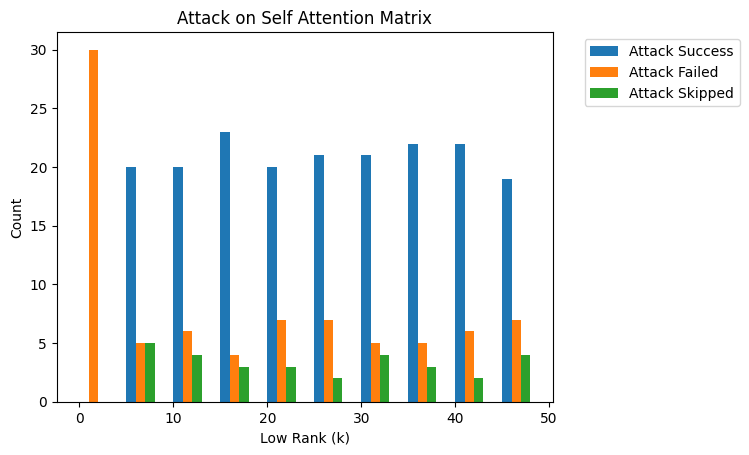

In [61]:
bar_width = 1
plt.bar(np.arange(1, 50, 5) - bar_width/2, success, width = bar_width, label="Attack Success")
plt.bar(np.arange(1, 50, 5) + bar_width/2, failed, width = bar_width, label="Attack Failed")
plt.bar(np.arange(1, 50, 5) + bar_width + bar_width/2, skipped, width = bar_width, label = "Attack Skipped")
plt.title("Attack on Self Attention Matrix")
plt.xlabel("Low Rank (k)")
plt.ylabel("Count")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()